### Cat Breed Detector
- Train own model
-  Retrain model

In [1]:
import torch
import numpy as np
import pandas as pd
import torchvision as tv
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from IPython import display
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import gradio as gr
import seaborn as sn
import tqdm
import wandb
#wandb.login('55b8041cd6000bec97e443682816312bd58b6304')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Let's get the data
- A folder called 'datasets' is present in the directory. It contains all data gathered from Kaggle.
- Use transform (experiment with transformations)

In [2]:
transform = tv.transforms.Compose([tv.transforms.Resize(256),
                                tv.transforms.CenterCrop(256),
                                tv.transforms.ToTensor()])

training_data_complete = tv.datasets.ImageFolder(
    root= './datasets/',
    transform=transform
)

print('Amount of training images: {}'.format(len(training_data_complete)))
print('Amount of training classes and their indices: {}'.format(training_data_complete.class_to_idx))

Amount of training images: 5625
Amount of training classes and their indices: {'Abyssinian': 0, 'American Bobtail': 1, 'American Shorthair': 2, 'Bengal': 3, 'Birman': 4, 'Bombay': 5, 'British Shorthair': 6, 'Egyptian Mau': 7, 'Maine Coon': 8, 'Persian': 9, 'Ragdoll': 10, 'Russian Blue': 11, 'Siamese': 12, 'Sphynx': 13, 'Tuxedo': 14}


### Split up the data intro training, validation and test set 
- This code is similar to the one professor Tassel showed us in the PR ML&DL course in almost all examples https://nbviewer.org/github/ingambe/PracticumAAUDeepLearning/tree/master/2-Linear-networks/Slides/
- I used 80% as size for the training data  

In [3]:
training_size = int(0.8 * len(training_data_complete))
validation_size = len(training_data_complete) - training_size
training_data, validation_data = torch.utils.data.random_split(training_data_complete, [training_size, validation_size], generator=torch.Generator().manual_seed(0))

training_size = int(0.8 * len(training_data))
test_size = len(training_data) - training_size
training_data, test_data = torch.utils.data.random_split(training_data, [training_size, test_size], generator=torch.Generator().manual_seed(0))

print('Amount of training images: {}'.format(training_size))
print('Amount of validation images: {}'.format(validation_size))
print('Amount of test images: {}'.format(test_size))

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader =  DataLoader(validation_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)

Amount of training images: 3600
Amount of validation images: 1125
Amount of test images: 900


I had a lot of troubles with finding a model which didn't bring my PC out of memory and to basically die.
Following website offered me the final hint of how to combine the layers to achieve:
- https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/
The model below is very much inspired by the model on this tutorial as without the reshaping and pooling I wasn't able to achieve any result.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.c1 = nn.Conv2d(3,20,5)
        self.c2 = nn.Conv2d(20,50,5)
        self.c3 = nn.Conv2d(50,100,5)
        self.c4 = nn.Conv2d(100,160,5)
        
        self.lin1 = nn.Linear(160, 15)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        #  The combination of maxpool with the rest in one line is copied from: https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/
        # I ran into problems when trying different
        x = self.maxpool(self.relu(self.c1(x)))
        x = self.maxpool(self.relu(self.c2(x)))
        x = self.dropout(x)
        x = self.maxpool(self.relu(self.c3(x)))
        x = self.maxpool(self.relu(self.c4(x)))
        #  begin This code is copied from https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/
        bs, _, _, _ = x.shape
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        # End
        x = self.lin1(x)
        return x

The training and validation loop is inspired by the things learned in the course of Prof. Tassel. https://nbviewer.org/github/ingambe/PracticumAAUDeepLearning/tree/master/2-Linear-networks/Slides/
and by my submission in this course available under following link https://www.kaggle.com/code/stenglx/mnist-cnn

In [5]:
def training_and_validation_loop(model, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epochs):
    lr = 1e-3
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        loss = 0
        classified_correctly = 0
        epoch_loss = 0
        counter = 0
        for image, label in train_dataloader:
            counter += 1
            optimizer.zero_grad()
            prediction = model(image)
            loss = criterion(prediction, label)

            _, predictions = torch.max(prediction.data, 1)
            classified_correctly += (predictions == label).sum().item()

            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_loss = epoch_loss / counter
        train_acc = classified_correctly / training_size # = amount of samples
        print('Train loss', train_loss, 'Train acc', train_acc)

        with torch.no_grad():
            loss = 0
            classified_correctly = 0
            epoch_loss = 0
            counter = 0
            for image, label in validation_dataloader:
                counter += 1
                optimizer.zero_grad()
                prediction = model(image)
                loss = criterion(prediction, label)

                _, predictions = torch.max(prediction.data, 1)
                classified_correctly += (predictions == label).sum().item()

                epoch_loss += loss.item()

            valid_loss = epoch_loss / counter
            valid_acc = classified_correctly / validation_size # = amount of samples
            print('Valid loss', valid_loss, 'Valid acc', valid_acc)
            wandb.log({'Train_accuracy': train_acc, 'Validation_accuracy': valid_acc, 'Training_loss': train_loss, 'Validation_loss': valid_loss})
        
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc*100)
        valid_acc_list.append(valid_acc*100)

### Load pretrained model

In [7]:
model = tv.models.resnet18(pretrained=True)
wandb.init(project="Resnet18")
           
# only train last layer
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, 15)

training_loss=[]
validation_loss=[]
training_accuracy=[]
validation_accuracy=[]

training_and_validation_loop(model, training_loss,validation_loss,training_accuracy,validation_accuracy, 8)


### Train own model


In [15]:
model = Net()
wandb.init(project="Selfmade_CatModel")
training_loss=[]
validation_loss=[]
training_accuracy=[]
validation_accuracy=[]

training_and_validation_loop(model, training_loss,validation_loss,training_accuracy,validation_accuracy, 20)
torch.save(model, "./{}.pt".format('own_model'))

In [8]:
def test_on_testset(model, test_set):
    true_labels = []
    predicted_labels = []
    model.eval()
    for data, labels in test_set:
        true_labels.extend(labels.detach().numpy())
        with torch.no_grad():
            prediction = model(data)
            prediction = torch.argmax(prediction, dim=1)
            predicted_labels.extend(prediction.detach().numpy())
    
    report = classification_report(true_labels, predicted_labels)
    print(report)
    matrix = confusion_matrix(true_labels, predicted_labels)
    labels_cats = training_data_complete.classes
    
    matrix_df = pd.DataFrame(matrix, index = labels_cats, columns = labels_cats)
    cfm_plot = sn.heatmap(matrix_df, annot=True)
    cfm_plot.set(xlabel='Predicted label', ylabel='True label')

- Load model and test it on test set

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.27      0.13      0.17        70
           1       0.00      0.00      0.00        51
           2       0.25      0.09      0.14        64
           3       0.24      0.48      0.32        54
           4       0.43      0.10      0.16        59
           5       0.28      0.72      0.40        67
           6       0.10      0.08      0.09        53
           7       0.27      0.28      0.27        74
           8       0.00      0.00      0.00        60
           9       0.19      0.22      0.20        46
          10       0.50      0.09      0.16        64
          11       0.18      0.76      0.29        63
          12       0.42      0.25      0.31        61
          13       0.10      0.04      0.05        56
          14       0.26      0.16      0.20        58

    accuracy                           0.23       900
   macro avg       0.23      0.23      0.18       900
weighted avg       0.24   

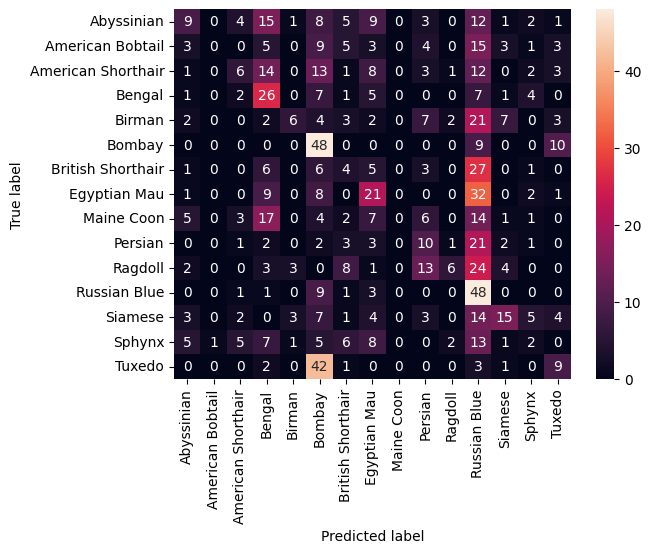

In [9]:
model = torch.load("own_model.pt")
test_on_testset(model, test_dataloader)

              precision    recall  f1-score   support

           0       0.92      0.70      0.80        70
           1       0.51      0.41      0.46        51
           2       0.62      0.47      0.54        64
           3       0.64      0.87      0.73        54
           4       0.74      0.76      0.75        59
           5       0.84      0.96      0.90        67
           6       0.73      0.68      0.71        53
           7       0.82      0.72      0.76        74
           8       0.74      0.90      0.81        60
           9       0.89      0.91      0.90        46
          10       0.76      0.64      0.69        64
          11       0.85      0.90      0.88        63
          12       0.84      0.95      0.89        61
          13       0.98      0.98      0.98        56
          14       0.82      0.95      0.88        58

    accuracy                           0.79       900
   macro avg       0.78      0.79      0.78       900
weighted avg       0.78   

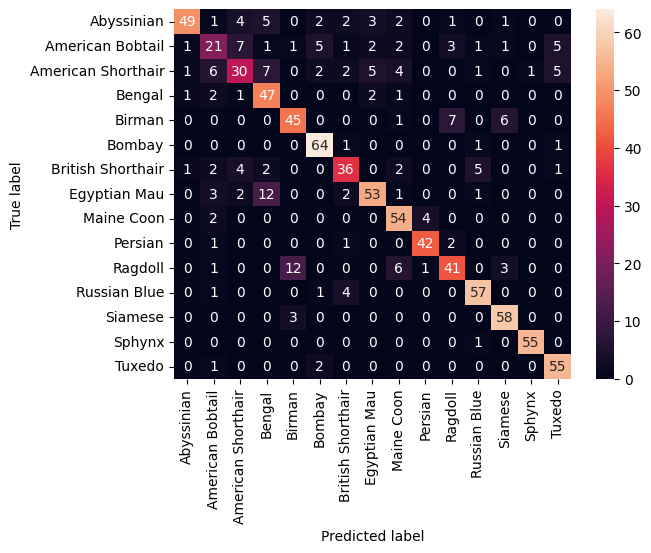

In [10]:
model = torch.load("resnet18-pretrained.pt")
test_on_testset(model, test_dataloader)


### User Interface 
- This code is inspired by the code of the notebook of Prof. Tassel from the course MLDL PR WS22/23.
- I used most of the code of the UI from this notebook and adapted it for my needs; https://nbviewer.org/github/ingambe/PracticumAAUDeepLearning/blob/master/4-CNN/Slides/3b-Gradio.ipynb

In [12]:
model = torch.load("resnet18-pretrained.pt")

labels_cats = training_data_complete.classes

def gr_func(image):
    image = tv.torchvision.transforms.Resize(256)(tv.torchvision.transforms.ToTensor()(image).unsqueeze(0))

    #print(img)
    with torch.inference_mode():
        prediction = torch.nn.functional.softmax(model(image)[0], dim=0)
        print(prediction)
        labels = {labels_cats[i]: float(prediction[i]) for i in range(len(labels_cats))}
    return labels

interface = gr.Interface(gr_func, 
                     inputs=gr.Image(), 
                     outputs=gr.Label(num_top_classes=15), 
                     live=True, 
                     title="Cat Breed Detector",
                     description="Upload an image of your cat and get to know its breed!",
                     interpretation='default').launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://18af2bd778afdbfa53.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
